In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import datetime
from sklearn.linear_model import LinearRegression

In [2]:
df_all = pd.read_csv(
    '/Users/maria/Documents/spiced/spiced_projects/week7/data/ECA_blended_custom/TG_STAID002759.txt', 
    skiprows=19, 
    skipinitialspace=True,
)

In [3]:
df_all

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
53352,111448,20220127,44,0
53353,111448,20220128,49,0
53354,111448,20220129,58,0
53355,111448,20220130,58,0


In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53357 entries, 0 to 53356
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SOUID   53357 non-null  int64
 1   DATE    53357 non-null  int64
 2   TG      53357 non-null  int64
 3   Q_TG    53357 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


In [5]:
df_all.describe()

,SOUID,DATE,TG,Q_TG
count,53357.000000,5.335700e+04,53357.000000,53357.000000
mean,119357.653541,1.948610e+07,57.050415,0.032910
std,8023.826001,4.217116e+05,614.099351,0.543108
min,111448.000000,1.876010e+07,-9999.000000,0.000000
25%,111448.000000,1.912071e+07,33.000000,0.000000
50%,111448.000000,1.949012e+07,94.000000,0.000000
75%,127488.000000,1.985072e+07,157.000000,0.000000
max,128124.000000,2.022013e+07,305.000000,9.000000


In [6]:
df_all.drop(['SOUID'], axis=1, inplace=True)

In [7]:
df_all['DATE'] = df_all['DATE'].astype(str)
df_all.set_index(pd.to_datetime(df_all['DATE']), inplace= True)
df_all.drop(['DATE'], axis=1, inplace=True)

In [8]:
df_all['T'] = df_all['TG']*0.1
df_all.drop(['TG'], axis=1, inplace=True)

In [9]:
df_all

,Q_TG,T
DATE,,
1876-01-01,0,2.2
1876-01-02,0,2.5
1876-01-03,0,0.3
1876-01-04,0,-5.8
1876-01-05,0,-9.8
...,...,...
2022-01-27,0,4.4
2022-01-28,0,4.9
2022-01-29,0,5.8


# Imputation

In [10]:
# Quality coloumn contains info for missing values
df_all['Q_TG'].value_counts()

0    53161
9      195
1        1
Name: Q_TG, dtype: int64

In [11]:
missing_values = df_all[df_all['Q_TG']==9]
missing_values.index 

DatetimeIndex(['1945-04-25', '1945-04-26', '1945-04-27', '1945-04-28',
               '1945-04-29', '1945-04-30', '1945-05-01', '1945-05-02',
               '1945-05-03', '1945-05-04',
               ...
               '1945-10-27', '1945-10-28', '1945-10-29', '1945-10-30',
               '1945-10-31', '1945-11-01', '1945-11-02', '1945-11-03',
               '1945-11-04', '1945-11-05'],
              dtype='datetime64[ns]', name='DATE', length=195, freq=None)

The 195 missing values are the days between 25.04.1945 and 05.11.1945. 

To impute them, I take the mean temperatures from 2 years before and two years after:

In [12]:
before = df_all.loc['1943-04-25':'1945-04-24']
after = df_all.loc['1945-11-06':'1947-11-05']
before = before.groupby([before.index.month, before.index.day]).mean()
after = after.groupby([after.index.month, after.index.day]).mean()

In [13]:
for date in missing_values.index:
    df_all.loc[date,'T'] = round((before.loc[(date.month,date.day),'T']+ 
                              after.loc[(date.month,date.day),'T'])/2,1)

In [14]:
# Quality coloumn is not needed any more
df_all.drop(['Q_TG'], axis=1, inplace=True)

# Train - Test Split

In [15]:
df = pd.DataFrame.copy(df_all.loc[:'2021-12-31'])

In [16]:
# Testing trend and seasonality on 1876-01-01 to 2016-12-31
df_train = pd.DataFrame.copy(df.loc[:'2016-12-31'])
df_test = pd.DataFrame.copy(df.loc['2017-01-01':])

# Visualization

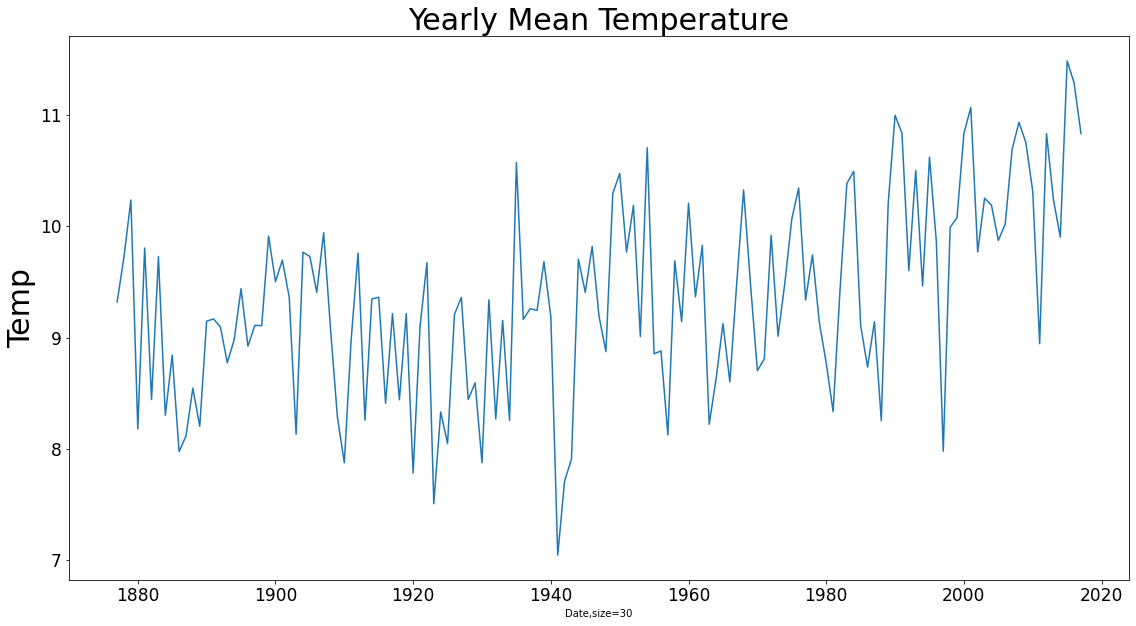

In [17]:
plt.figure(figsize=(19,10))
sns.lineplot(data =df_train.loc[:'2020-12-31'].resample('Y').mean(), y ='T', x ='DATE')
plt.ylabel('Temp',size=30)
plt.xlabel('Date,size=30')
plt.title('Yearly Mean Temperature',size=30)
plt.xticks(size=17)
plt.yticks(size=17)
plt.show()

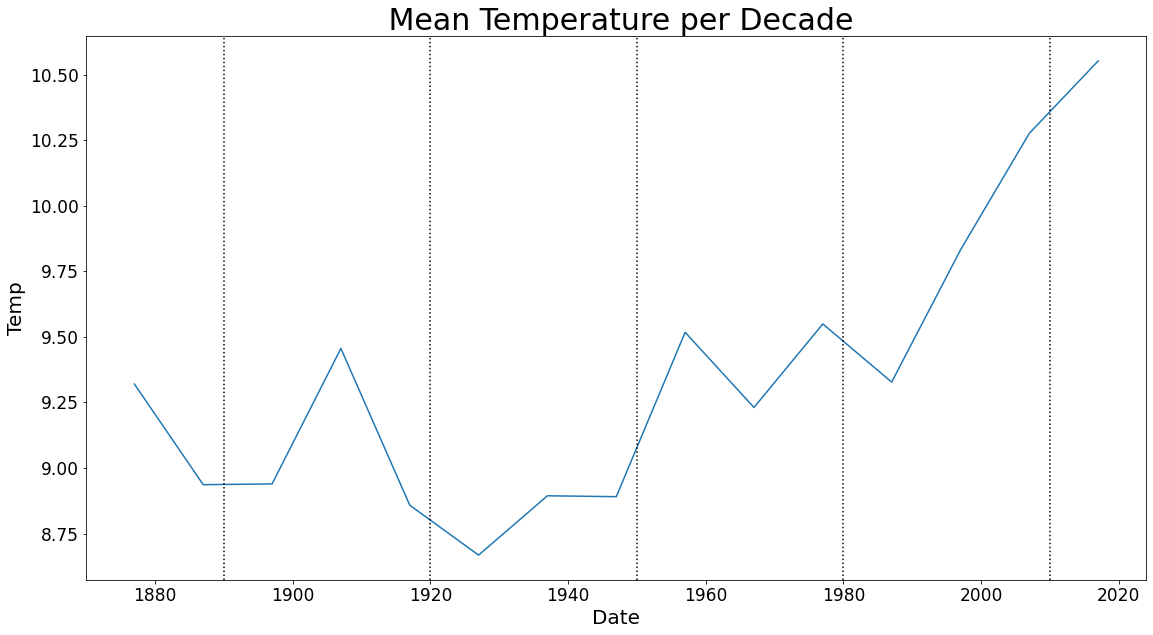

In [18]:
plt.figure(figsize=(19,10))
sns.lineplot(data =df_train.loc[:'2020-12-31'].resample('10Y').mean(), y ='T', x ='DATE')
plt.ylabel('Temp',size=20)
plt.xlabel('Date',size=20)
mod = [y for y in df_train.index.year if not y%30]
for year in set(mod):
   plt.axvline(datetime.datetime(year, 1, 1), color='black', ls=':')
plt.title(' Mean Temperature per Decade',size=30)
plt.xticks(size=17)
plt.yticks(size=17)
plt.show()

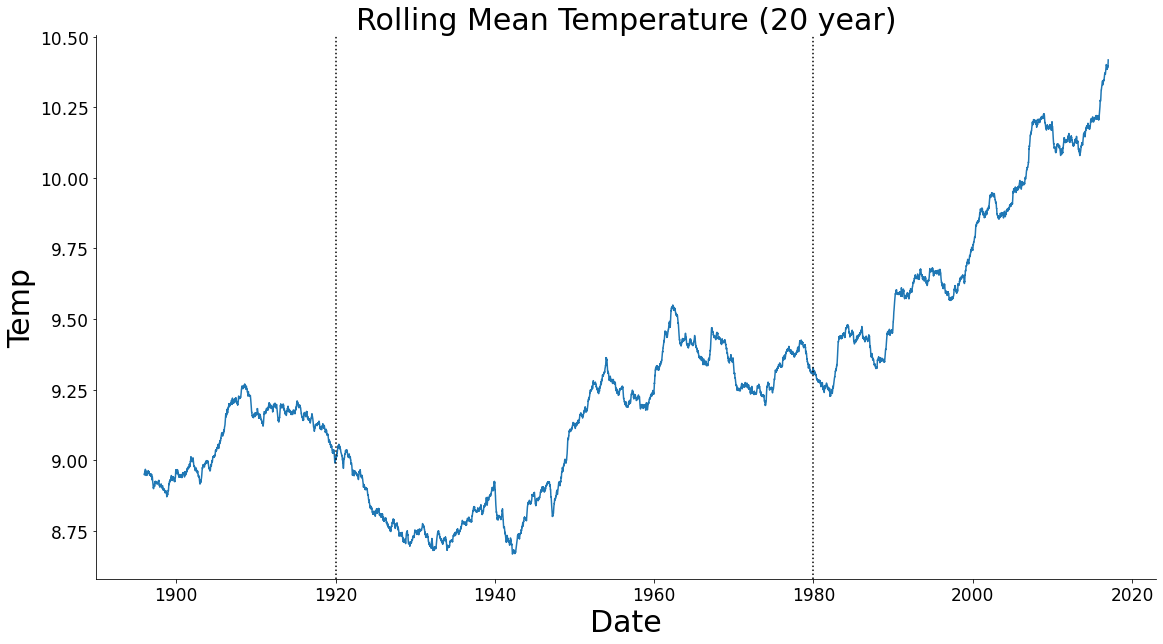

In [19]:

plt.figure(figsize=(19,10))
sns.lineplot(data = df_train.rolling(2*3652).mean(), y ='T', x ='DATE', markersize=12)
mod = [y for y in df_train.index.year if not y%60]
for year in set(mod):
   plt.axvline(datetime.datetime(year, 1, 1), color='black', ls=':')
plt.ylabel('Temp',size=30)
plt.xlabel('Date',size=30)
plt.title('Rolling Mean Temperature (20 year)',size=30)
plt.xticks(size=17)
plt.yticks(size=17)
sns.despine()

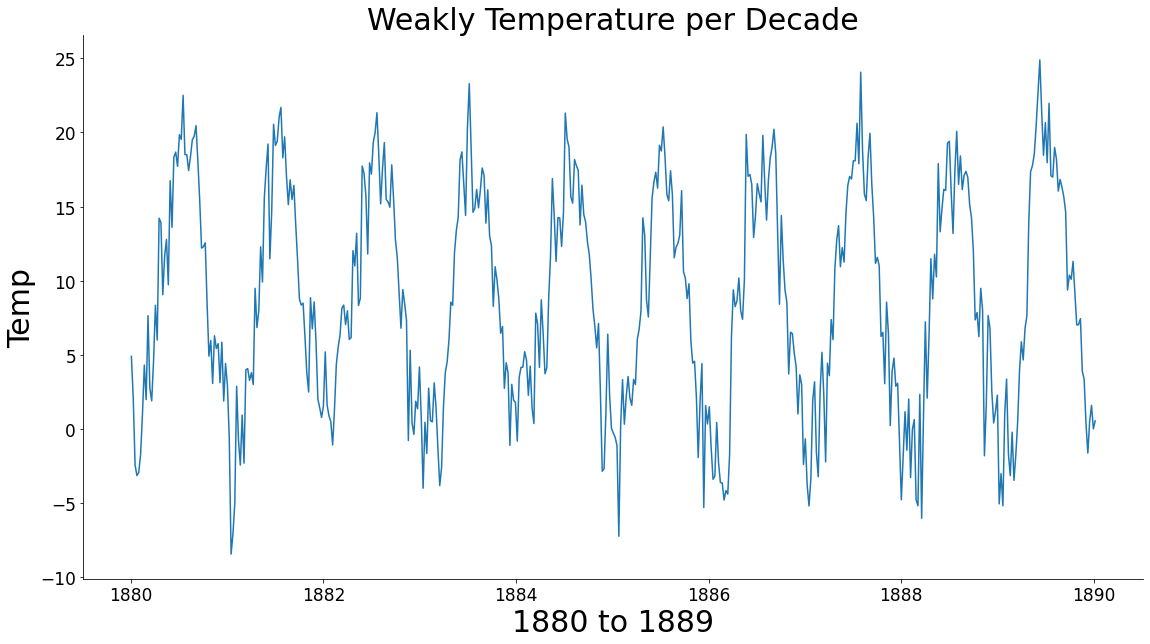

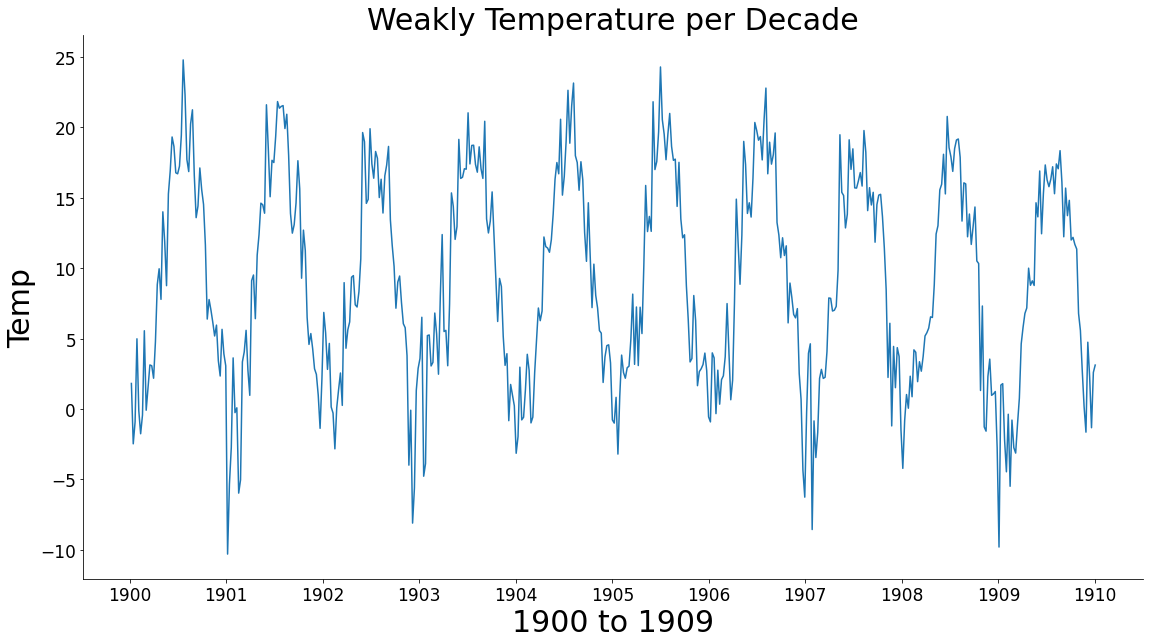

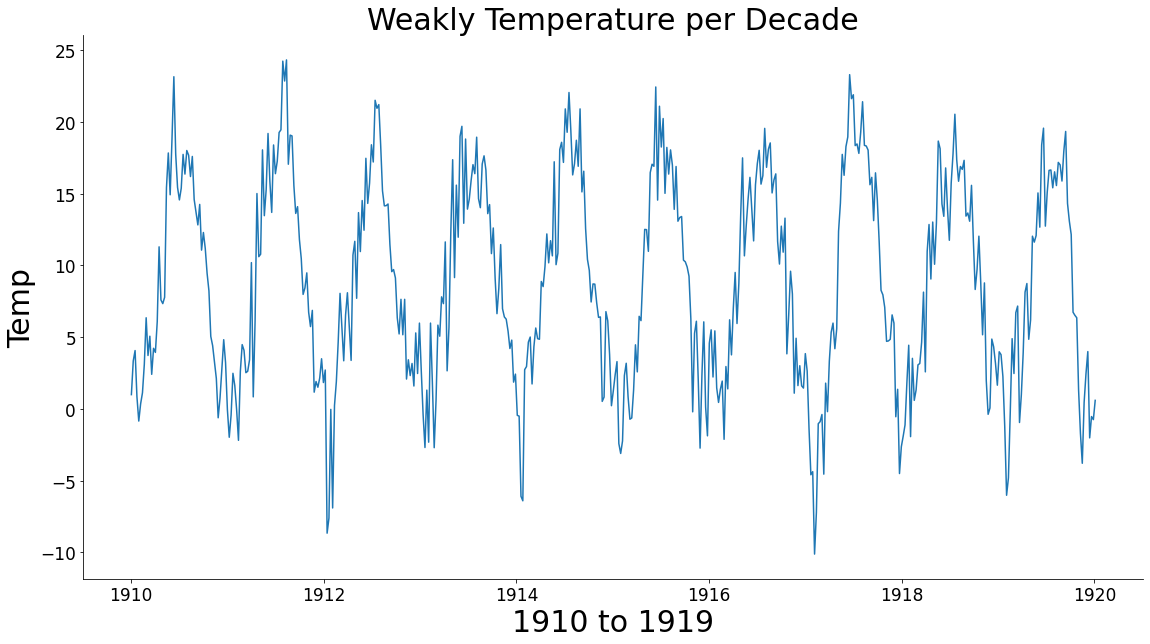

In [20]:
mod = [y for y in df_train.index.year if not y%10]
for decade in random.sample(mod[:-2],3):
    plt.figure(figsize=(19,10))
    start = f'{decade}-01-01'
    end = f'{decade+9}-12-31'
    sns.lineplot(data = df_train['T'].loc[start:end].resample('W').mean())
    plt.title('Weakly Temperature per Decade',size=30)
    plt.ylabel('Temp',size=30)
    plt.xlabel(f'{decade} to {decade+9}',size=30)  
    plt.xticks(size=17)
    plt.yticks(size=17)
    sns.despine()

# Creating dummy variables for trend

In [21]:
df

,T
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8
...,...
2021-12-27,-3.9
2021-12-28,-0.5
2021-12-29,4.5


In [22]:
df['timestep'] = list(range(len(df)))
df

,T,timestep
DATE,,
1876-01-01,2.2,0
1876-01-02,2.5,1
1876-01-03,0.3,2
1876-01-04,-5.8,3
1876-01-05,-9.8,4
...,...,...
2021-12-27,-3.9,53321
2021-12-28,-0.5,53322
2021-12-29,4.5,53323


In [23]:
df['timestep^2'] = df['timestep']**2
df

,T,timestep,timestep^2
DATE,,,
1876-01-01,2.2,0,0
1876-01-02,2.5,1,1
1876-01-03,0.3,2,4
1876-01-04,-5.8,3,9
1876-01-05,-9.8,4,16
...,...,...,...
2021-12-27,-3.9,53321,2843129041
2021-12-28,-0.5,53322,2843235684
2021-12-29,4.5,53323,2843342329


In [24]:
ramp_start = datetime.datetime(1950,1,1)
ramp = [0 for _ in range(len(df['timestep'].loc[:ramp_start])-1)]
ext = list(range(len(df['timestep'].loc[ramp_start:])))
ramp.extend(ext)
df['timestep_ramp'] = ramp

In [25]:
#df['global_warming_step'] = np.where(df.index.year>1950,1,0)
df # [df.index.year>1950]

,T,timestep,timestep^2,timestep_ramp
DATE,,,,
1876-01-01,2.2,0,0,0
1876-01-02,2.5,1,1,0
1876-01-03,0.3,2,4,0
1876-01-04,-5.8,3,9,0
1876-01-05,-9.8,4,16,0
...,...,...,...,...
2021-12-27,-3.9,53321,2843129041,26293
2021-12-28,-0.5,53322,2843235684,26294
2021-12-29,4.5,53323,2843342329,26295


In [26]:
X_train_tr = df.drop('T', axis=1).loc[:'2016-12-31']
y_train = df['T'].loc[:'2016-12-31']
X_test_tr = df.drop('T', axis=1).loc['2017-01-01':]
y_test = df['T'].loc['2017-01-01':]

In [27]:
m_trend = LinearRegression()
m_trend.fit(X_train_tr, y_train)
df['trend'] = 0
df['trend'].loc[:'2016-12-31'] = m_trend.predict(X_train_tr)
df['trend'].loc['2017-01-01':] = m_trend.predict(X_test_tr)
m_trend.score(X_train_tr, y_train)

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.004145606631265952

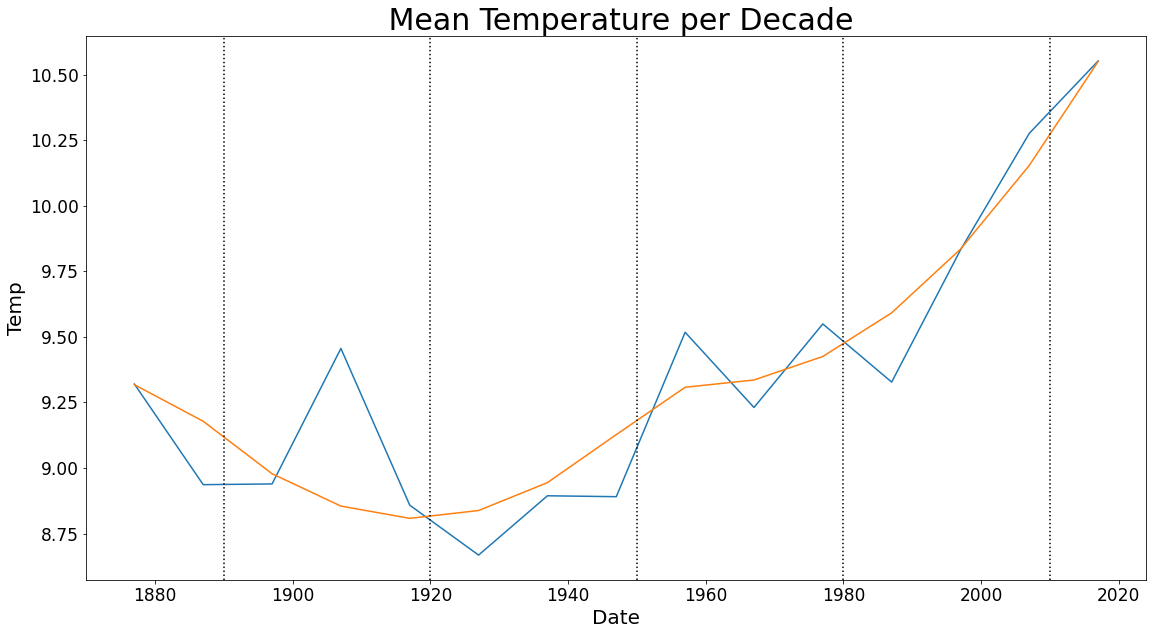

In [28]:
plt.figure(figsize=(19,10))
sns.lineplot(data =df.loc[:'2016-12-31'].resample('10Y').mean(), y ='T', x ='DATE')
sns.lineplot(data =df.loc[:'2016-12-31'].resample('10Y').mean(), y ='trend', x ='DATE')
plt.ylabel('Temp',size=20)
plt.xlabel('Date',size=20)
mod = [y for y in df_train.index.year if not y%30]
for year in set(mod):
   plt.axvline(datetime.datetime(year, 1, 1), color='black', ls=':')
plt.title(' Mean Temperature per Decade',size=30)
plt.xticks(size=17)
plt.yticks(size=17)
plt.show()

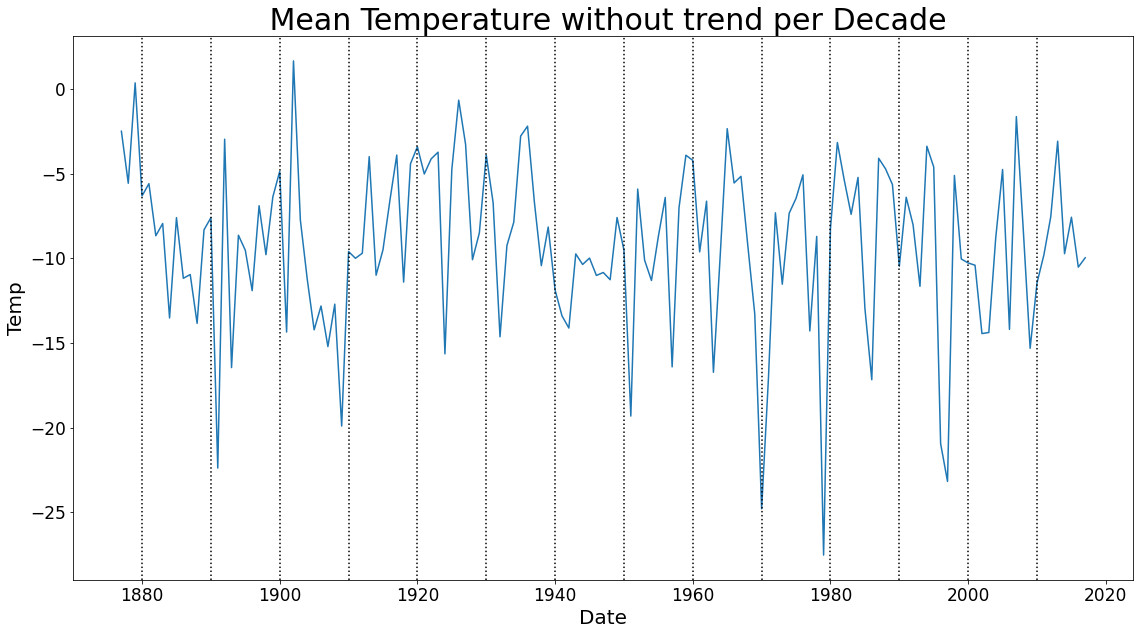

In [29]:
signal = df['T'] - df['trend']
plt.figure(figsize=(19,10))
sns.lineplot(data =df.loc[:'2016-12-31'].resample('Y').mean(), y =signal, x ='DATE')
#sns.lineplot(data =signal.loc[:'2016-12-31'].resample('10Y').mean(), y ='trend', x ='DATE')
plt.ylabel('Temp',size=20)
plt.xlabel('Date',size=20)
mod = [y for y in df_train.index.year if not y%10]
for year in set(mod):
   plt.axvline(datetime.datetime(year, 1, 1), color='black', ls=':')
plt.title(' Mean Temperature without trend per Decade',size=30)
plt.xticks(size=17)
plt.yticks(size=17)
plt.show()

# Cycles of climate? 
### Most important: Yearly Orbit around the Sun
Solar activity: 
  * multiples of 22.75 years
  * intensity increase slowly and then decrease sharply, with a period of about 80-100 years
Ocean-atmosphere interactions: 
 1. El Niño-Southern Oscillation (ENSO): 
  * an interaction between ocean temperatures and atmospheric patterns 
  * 3 to 7 
  * years different weather conditions to different parts of the world (NASA 2009)

2. Pacific Decadal Oscillation (PDO): 
  * occurs in cycles of 25-45 years (Mantua et al. 1997), 

3. Atlantic Multi-decadal Oscillation (AMO):
  * occurring on approximately 65-85 year cycles (Deser et al. 2010). 
  * interaction with the enhanced greenhouse effect (Li et al. 2013).
### Non periodic effects
Orbit around the Sun:
  * changes in eccentricity
  * changes in the tilt of the earth's axis

Random events:
  * Volcanos
  * meteorites
  * comets

Human:
  * Greenhouse gases
  * industrial pollution particles
  * ozone depletion

source:  
 * https://www.fs.usda.gov/ccrc/education/climate-primer/natural-climate-cycles
 * http://dmod.physics.auth.gr/klima_02.htm
 

# Fast Fourier Transform

In [30]:
signal = df['T'] - df['trend']
signal = signal.resample('20m').mean()

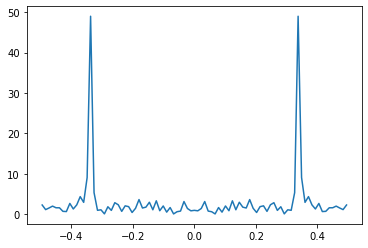

In [31]:
n = len(signal)
# fast fourier transform
TG_hat = np.fft.fft(signal,n)
# power spectral density
psd = TG_hat * np.conj(TG_hat)/n
# frequency in years
# freq =np.arange(n)/n
freq = np.fft.fftfreq(signal.shape[-1])
sns.lineplot(x=freq,y=np.absolute(psd))
None

In [32]:
signal = df['T'] - df['trend']
signal = signal.resample('Y').mean()

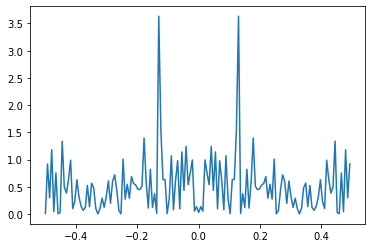

In [33]:
n = len(signal)
# fast fourier transform
TG_hat = np.fft.fft(signal,n)
# power spectral density
psd = TG_hat * np.conj(TG_hat)/n
# frequency in years
# freq =np.arange(n)/n
freq = np.fft.fftfreq(signal.shape[-1])
sns.lineplot(x=freq,y=np.absolute(psd))
None

In [34]:
for num,p in np.ndenumerate(psd):
    if num[0]==0: continue
    if (np.absolute(p)>3):
        print(p,n/num[0])

(3.6323063610566684+0j) 7.684210526315789
(3.6323063610566675+0j) 1.1496062992125984


# Creating dummy variables for cycles

I will create one or yearly periodicity with monthly resolution and one for the ~60 year (not so normal) cycles

In [35]:
df['cycle_1'] = df.index.month
df['cycle_2'] = df.index.year%11
df['cycle_3'] = df.index.year%24
df['cycle_4'] = df.index.year%36
df['cycle_5'] = df.index.year%60
df.columns

Index(['T', 'timestep', 'timestep^2', 'timestep_ramp', 'trend', 'cycle_1',
       'cycle_2', 'cycle_3', 'cycle_4', 'cycle_5'],
      dtype='object')

In [36]:
df = pd.get_dummies(df, columns=['cycle_1', 'cycle_2', 'cycle_3', 'cycle_4', 'cycle_5'], drop_first=True, )

In [37]:
X_train_fe = df.drop('T', axis=1).loc[:'2016-12-31']
y_train = df['T'].loc[:'2016-12-31']
X_test_fe = df.drop('T', axis=1).loc['2017-01-01':]
y_test = df['T'].loc['2017-01-01':]

In [38]:
X_train_fe.columns

Index(['timestep', 'timestep^2', 'timestep_ramp', 'trend', 'cycle_1_2',
       'cycle_1_3', 'cycle_1_4', 'cycle_1_5', 'cycle_1_6', 'cycle_1_7',
       ...
       'cycle_5_50', 'cycle_5_51', 'cycle_5_52', 'cycle_5_53', 'cycle_5_54',
       'cycle_5_55', 'cycle_5_56', 'cycle_5_57', 'cycle_5_58', 'cycle_5_59'],
      dtype='object', length=142)

In [39]:
y_test

DATE
2017-01-01     2.3
2017-01-02     1.0
2017-01-03     2.7
2017-01-04     2.5
2017-01-05    -2.9
              ... 
2021-12-27    -3.9
2021-12-28    -0.5
2021-12-29     4.5
2021-12-30     9.3
2021-12-31    13.0
Name: T, Length: 1826, dtype: float64

In [40]:
m = LinearRegression()
m.fit(X_train_fe, y_train)
df['seasonal_trend'] = 0
df['seasonal_trend'].loc[:'2016-12-31'] = m.predict(X_train_fe)
df['seasonal_trend'].loc['2017-01-01':] = m.predict(X_test_fe)
m.score(X_train_fe, y_train)

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.7593701626858904

<AxesSubplot:xlabel='DATE'>

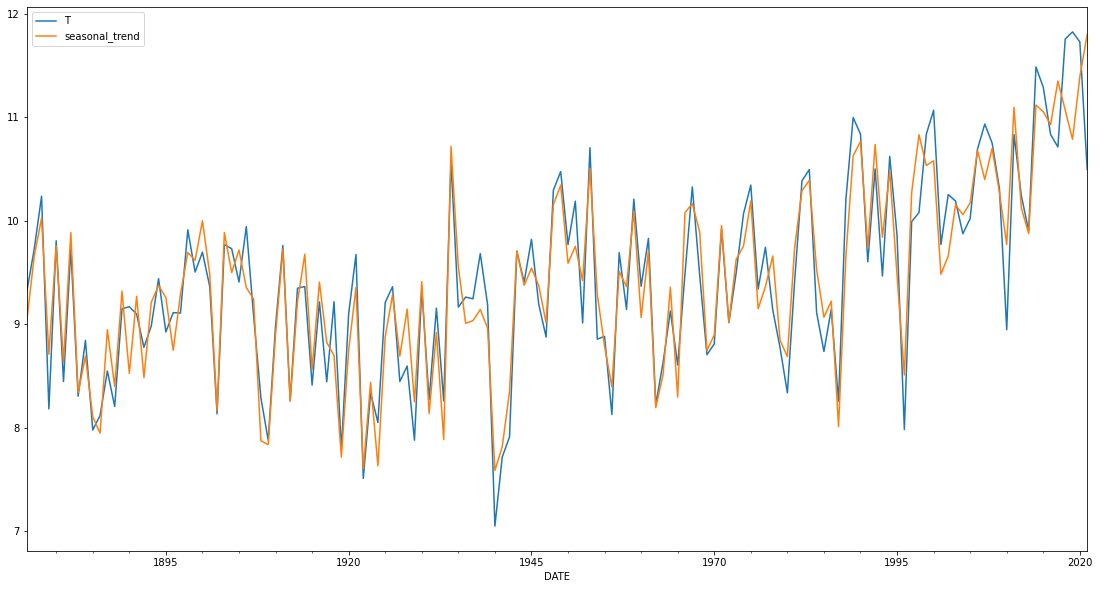

In [41]:
df[['T', 'seasonal_trend']].resample('y').mean().plot(figsize=(19,10))

In [42]:
df['remainder']=df['T']-df['seasonal_trend']

In [43]:
df[['remainder']].describe()

,remainder
count,53326.000000
mean,0.000801
std,3.858979
min,-22.371661
25%,-2.568453
50%,-0.031348
75%,2.619278
max,14.443298


<AxesSubplot:xlabel='DATE'>

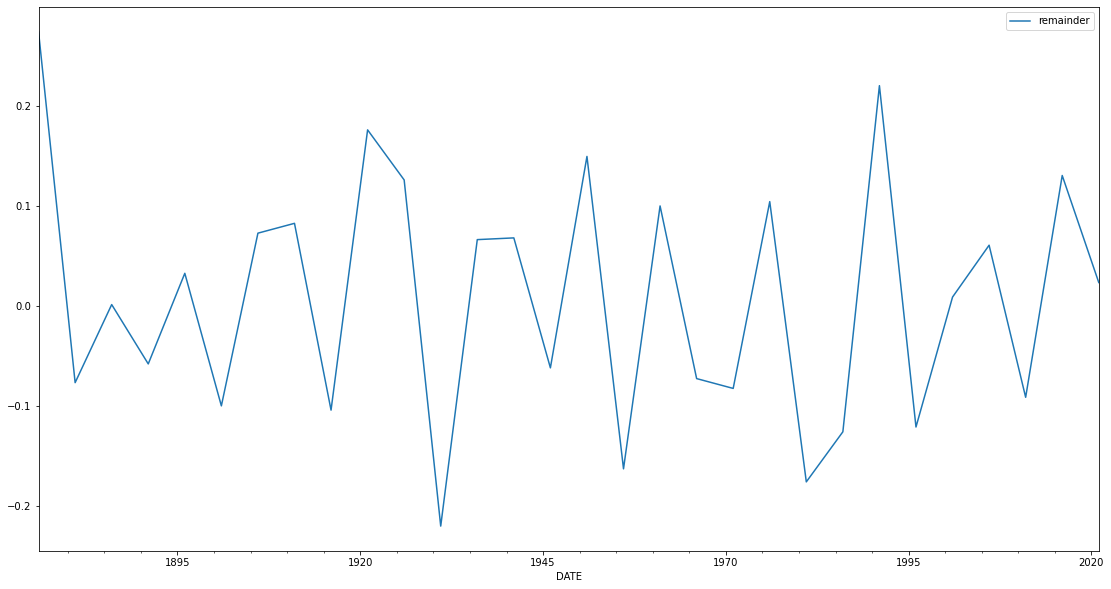

In [44]:
df[['remainder']].resample('5Y').mean().plot(figsize=(19,10))

Text(0, 0.5, 'Partial Autocorrelation')

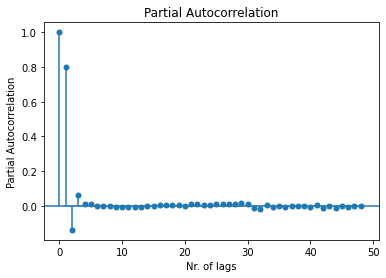

In [45]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['remainder'])
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')

In [46]:
df['lag1'] = df['T'].shift(1) #df['remainder'].shift(1)
df['lag2'] = df['T'].shift(2)#df['remainder'].shift(2)
df['lag3'] = df['T'].shift(3) #df['remainder'].shift(3)

In [47]:
df

,T,timestep,timestep^2,timestep_ramp,trend,cycle_1_2,cycle_1_3,cycle_1_4,cycle_1_5,cycle_1_6,...,cycle_5_55,cycle_5_56,cycle_5_57,cycle_5_58,cycle_5_59,seasonal_trend,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,2.2,0,0,0,9.331835,0,0,0,0,0,...,0,0,0,0,0,-0.368825,2.568825,NaN,NaN,NaN
1876-01-02,2.5,1,1,0,9.331757,0,0,0,0,0,...,0,0,0,0,0,-0.368805,2.868805,2.2,NaN,NaN
1876-01-03,0.3,2,4,0,9.331679,0,0,0,0,0,...,0,0,0,0,0,-0.368784,0.668784,2.5,2.2,NaN
1876-01-04,-5.8,3,9,0,9.331602,0,0,0,0,0,...,0,0,0,0,0,-0.368763,-5.431237,0.3,2.5,2.2
1876-01-05,-9.8,4,16,0,9.331524,0,0,0,0,0,...,0,0,0,0,0,-0.368742,-9.431258,-5.8,0.3,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-3.9,53321,2843129041,26293,11.019958,0,0,0,0,0,...,0,0,0,0,0,3.720111,-7.620111,-6.8,-5.5,2.0
2021-12-28,-0.5,53322,2843235684,26294,11.020098,0,0,0,0,0,...,0,0,0,0,0,3.720156,-4.220156,-3.9,-6.8,-5.5
2021-12-29,4.5,53323,2843342329,26295,11.020238,0,0,0,0,0,...,0,0,0,0,0,3.720201,0.779799,-0.5,-3.9,-6.8


In [48]:
df.dropna(inplace=True)

In [49]:
X_train_fe = df.drop(columns=['T', 'seasonal_trend', 'remainder','trend']).loc[:'2016-12-31']
y_train = df['T'].loc[:'2016-12-31']
X_test_fe = df.drop(columns=['T', 'seasonal_trend', 'remainder','trend']).loc['2017-01-01':]
y_test = df['T'].loc['2017-01-01':]
X_train_fe.columns

Index(['timestep', 'timestep^2', 'timestep_ramp', 'cycle_1_2', 'cycle_1_3',
       'cycle_1_4', 'cycle_1_5', 'cycle_1_6', 'cycle_1_7', 'cycle_1_8',
       ...
       'cycle_5_53', 'cycle_5_54', 'cycle_5_55', 'cycle_5_56', 'cycle_5_57',
       'cycle_5_58', 'cycle_5_59', 'lag1', 'lag2', 'lag3'],
      dtype='object', length=144)

In [50]:
m_full = LinearRegression()
m_full.fit(X_train_fe, y_train)
print(m_full.score(X_train_fe, y_train))
df['pred_full'] = 0
df['pred_full'].loc[:'2016-12-31'] = m_full.predict(X_train_fe)
df['pred_full'].loc['2017-01-01':] = m_full.predict(X_test_fe)

0.9191746546857318


/Users/maria/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [51]:
df

,T,timestep,timestep^2,timestep_ramp,trend,cycle_1_2,cycle_1_3,cycle_1_4,cycle_1_5,cycle_1_6,...,cycle_5_56,cycle_5_57,cycle_5_58,cycle_5_59,seasonal_trend,remainder,lag1,lag2,lag3,pred_full
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-04,-5.8,3,9,0,9.331602,0,0,0,0,0,...,0,0,0,0,-0.368763,-5.431237,0.3,2.5,2.2,-0.119234
1876-01-05,-9.8,4,16,0,9.331524,0,0,0,0,0,...,0,0,0,0,-0.368742,-9.431258,-5.8,0.3,2.5,-5.297021
1876-01-06,-7.7,5,25,0,9.331446,0,0,0,0,0,...,0,0,0,0,-0.368721,-7.331279,-9.8,-5.8,0.3,-7.932647
1876-01-07,-6.6,6,36,0,9.331368,0,0,0,0,0,...,0,0,0,0,-0.368700,-6.231300,-7.7,-9.8,-5.8,-5.663499
1876-01-08,-8.9,7,49,0,9.331290,0,0,0,0,0,...,0,0,0,0,-0.368680,-8.531320,-6.6,-7.7,-9.8,-5.400802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-3.9,53321,2843129041,26293,11.019958,0,0,0,0,0,...,0,0,0,0,3.720111,-7.620111,-6.8,-5.5,2.0,-4.321997
2021-12-28,-0.5,53322,2843235684,26294,11.020098,0,0,0,0,0,...,0,0,0,0,3.720156,-4.220156,-3.9,-6.8,-5.5,-1.979237
2021-12-29,4.5,53323,2843342329,26295,11.020238,0,0,0,0,0,...,0,0,0,0,3.720201,0.779799,-0.5,-3.9,-6.8,0.471162


No handles with labels found to put in legend.
No handles with labels found to put in legend.


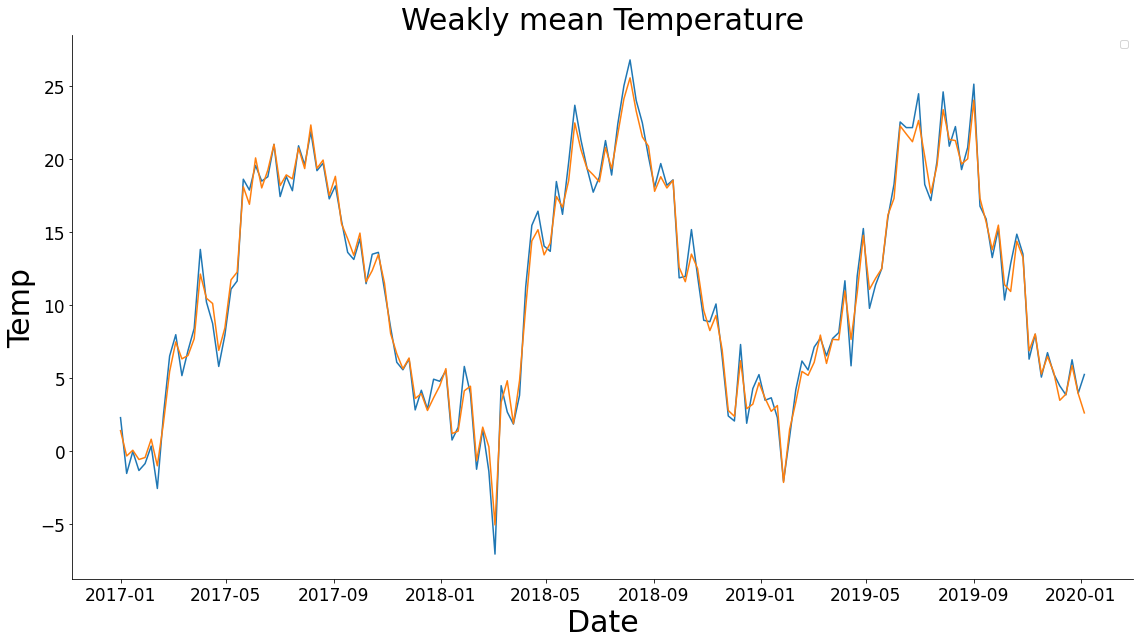

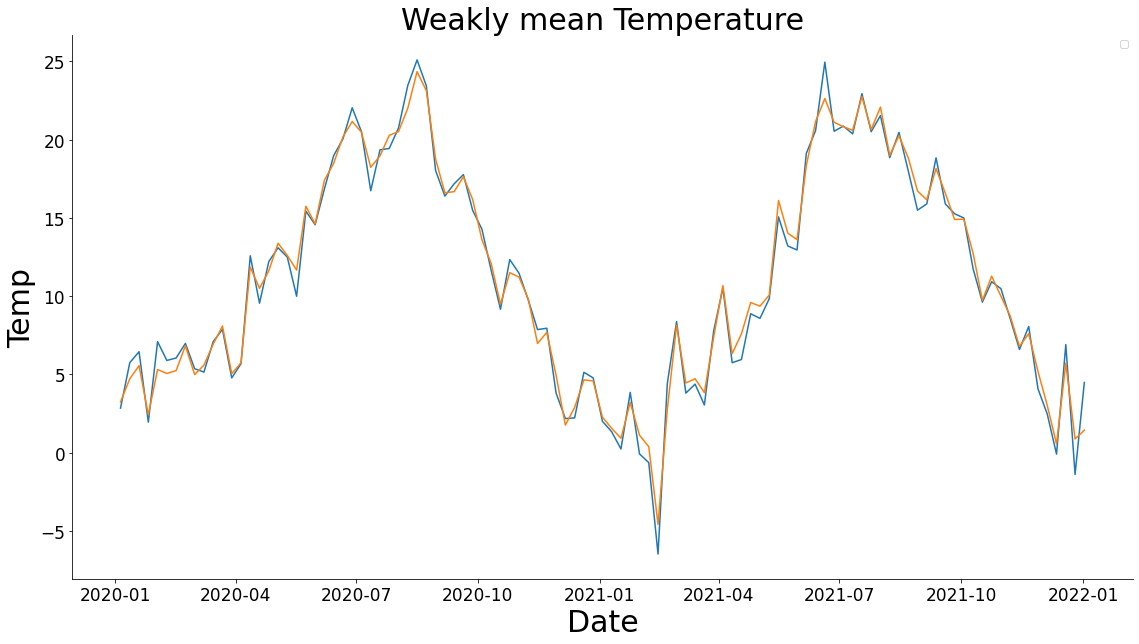

In [52]:
mod = [2017,2020,]
for year in mod:
    plt.figure(figsize=(19,10))
    start = f'{year}-01-01'
    end = f'{year+2}-12-31'
    sns.lineplot(data = df['T'].loc[start:end].resample('W').mean())
    sns.lineplot(data = df['pred_full'].loc[start:end].resample('W').mean())
    plt.title('Weakly mean Temperature',size=30)
    plt.ylabel('Temp',size=30)
    plt.xlabel('Date',size=30)  
    plt.xticks(size=17)
    plt.yticks(size=17)
    plt.legend()
    sns.despine()

<AxesSubplot:xlabel='DATE'>

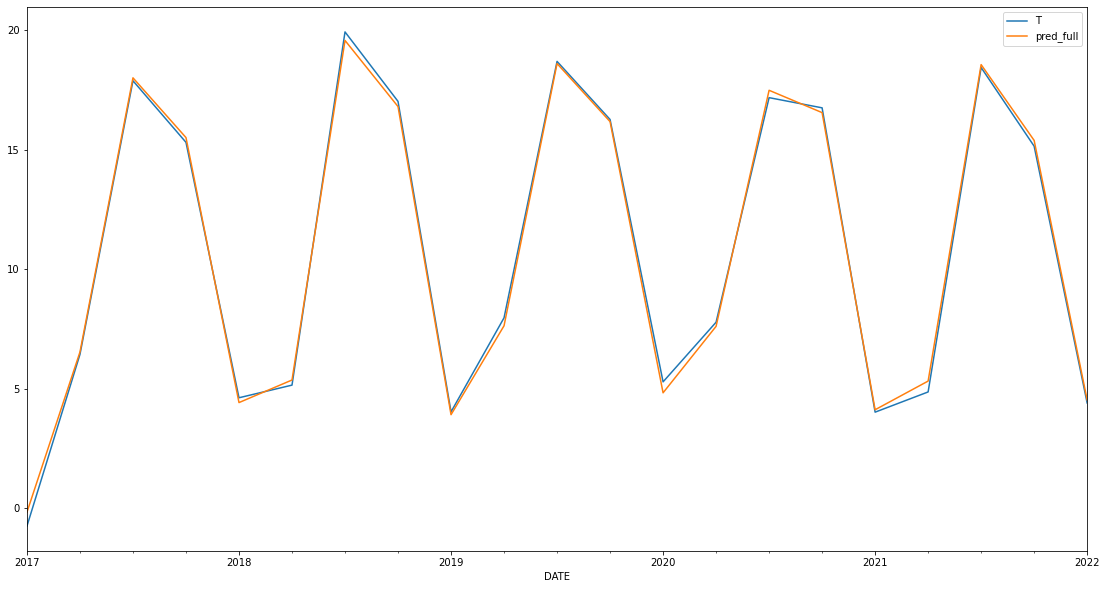

In [53]:
df[['T', 'pred_full']].loc['2017-01-01':].resample('3M').mean().plot(figsize=(19,10))

<AxesSubplot:xlabel='DATE'>

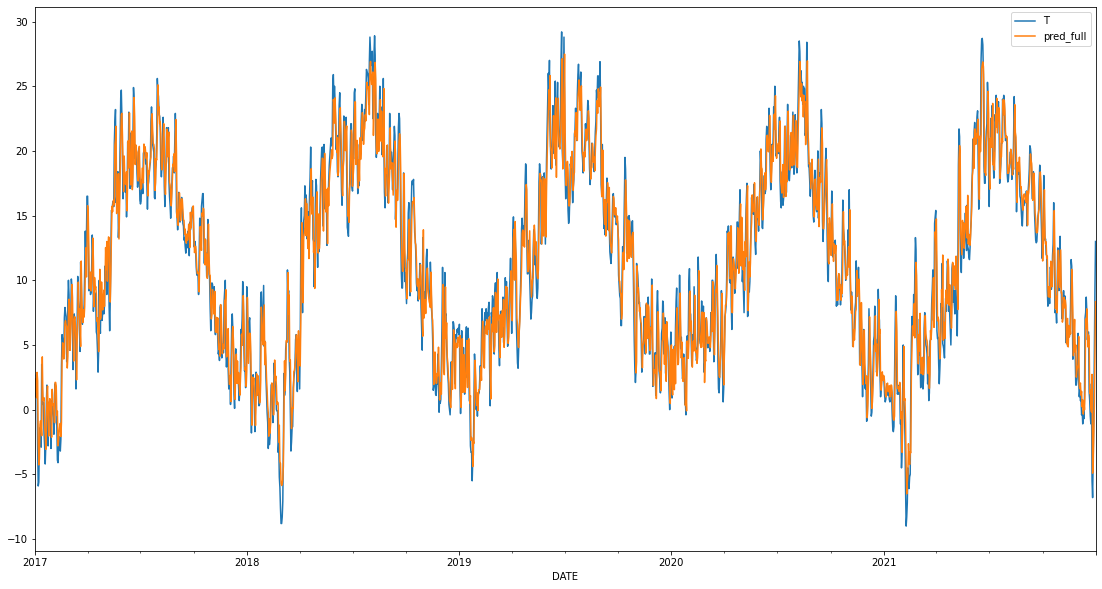

In [54]:
df[['T', 'pred_full']].loc['2017-01-01':].resample('d').mean().plot(figsize=(19,10))

<AxesSubplot:xlabel='DATE'>

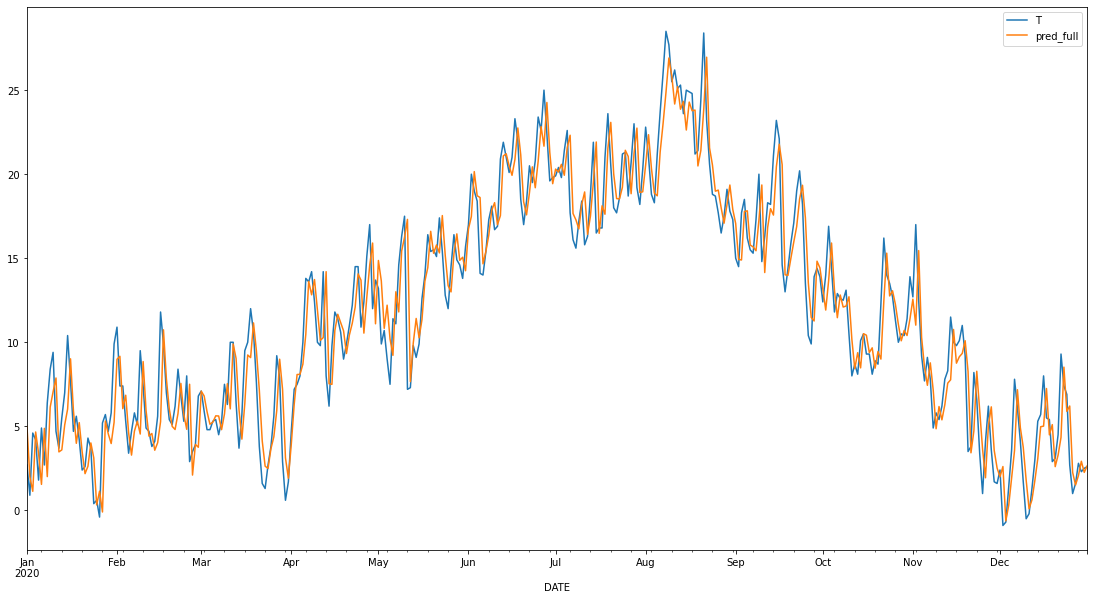

In [55]:
n = df.loc['2020-01-01':'2020-12-31']
n[['T', 'pred_full']].plot(figsize=(19,10))

<AxesSubplot:xlabel='DATE'>

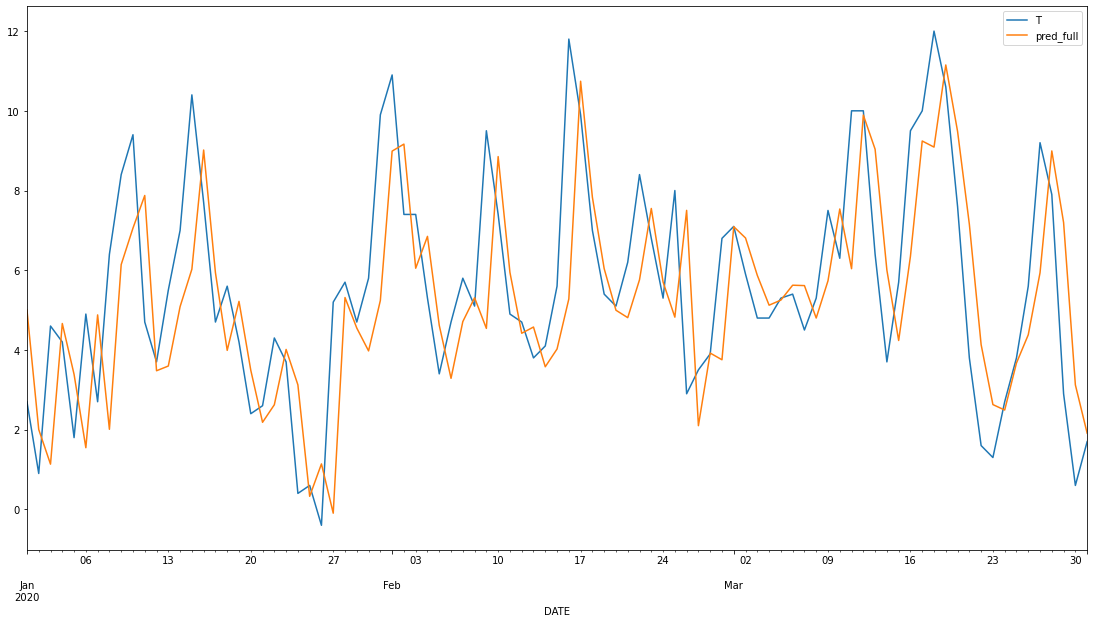

In [56]:
n = df.loc['2020-01-01':'2020-03-31']
n[['T', 'pred_full']].plot(figsize=(19,10))

In [57]:
from sklearn.metrics import r2_score
r2_score(df['T'],df['pred_full'])

0.9194833885287075

In [58]:
# TODO evaluation

Trend and seasonality work well. Next step, train all together and future prediction

In [59]:
df.columns

Index(['T', 'timestep', 'timestep^2', 'timestep_ramp', 'trend', 'cycle_1_2',
       'cycle_1_3', 'cycle_1_4', 'cycle_1_5', 'cycle_1_6',
       ...
       'cycle_5_56', 'cycle_5_57', 'cycle_5_58', 'cycle_5_59',
       'seasonal_trend', 'remainder', 'lag1', 'lag2', 'lag3', 'pred_full'],
      dtype='object', length=149)

In [60]:
X_train_f = df.drop(columns=['seasonal_trend', 'remainder', 'pred_full', 'T',])

In [61]:
m_final = LinearRegression()
m_final.fit(X_train_f, df['T'])
print(m_final.score(X_train_f, df['T']))
df['pred_final']= m_final.predict(X_train_f)

0.919495788147483


# Future Prediction

In [62]:
df

,T,timestep,timestep^2,timestep_ramp,trend,cycle_1_2,cycle_1_3,cycle_1_4,cycle_1_5,cycle_1_6,...,cycle_5_57,cycle_5_58,cycle_5_59,seasonal_trend,remainder,lag1,lag2,lag3,pred_full,pred_final
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-04,-5.8,3,9,0,9.331602,0,0,0,0,0,...,0,0,0,-0.368763,-5.431237,0.3,2.5,2.2,-0.119234,-0.130076
1876-01-05,-9.8,4,16,0,9.331524,0,0,0,0,0,...,0,0,0,-0.368742,-9.431258,-5.8,0.3,2.5,-5.297021,-5.313184
1876-01-06,-7.7,5,25,0,9.331446,0,0,0,0,0,...,0,0,0,-0.368721,-7.331279,-9.8,-5.8,0.3,-7.932647,-7.936302
1876-01-07,-6.6,6,36,0,9.331368,0,0,0,0,0,...,0,0,0,-0.368700,-6.231300,-7.7,-9.8,-5.8,-5.663499,-5.654177
1876-01-08,-8.9,7,49,0,9.331290,0,0,0,0,0,...,0,0,0,-0.368680,-8.531320,-6.6,-7.7,-9.8,-5.400802,-5.403430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-3.9,53321,2843129041,26293,11.019958,0,0,0,0,0,...,0,0,0,3.720111,-7.620111,-6.8,-5.5,2.0,-4.321997,-4.468326
2021-12-28,-0.5,53322,2843235684,26294,11.020098,0,0,0,0,0,...,0,0,0,3.720156,-4.220156,-3.9,-6.8,-5.5,-1.979237,-2.123977
2021-12-29,4.5,53323,2843342329,26295,11.020238,0,0,0,0,0,...,0,0,0,3.720201,0.779799,-0.5,-3.9,-6.8,0.471162,0.320723


In [63]:
df.iloc[-3:].index

DatetimeIndex(['2021-12-29', '2021-12-30', '2021-12-31'], dtype='datetime64[ns]', name='DATE', freq=None)

In [64]:
def mod_list(n,m):
    d = [0]*n
    mod = m%n
    d[mod] = 1
    return(d[1:])

In [65]:
future_day = df.index.max()+datetime.timedelta(days=1)

timestep = df['timestep'].max() + 1
timestep_ramp = df['timestep_ramp'].max()  + 1
timesteps = [timestep, timestep**2,timestep_ramp]#global_warming_step]

cycle_1 = mod_list(12,future_day.month) 
cycle_2 = mod_list(11,future_day.year)
cycle_3 = mod_list(24,future_day.year)
cycle_4 = mod_list(36,future_day.year)
cycle_5 = mod_list(60,future_day.year)

lag1 = df.loc[df.index.max(), 'T'] # taking the last remainder 
lag2 = df.loc[df.index.max()-datetime.timedelta(days=1), 'T'] # taking the last remainder 
lag3 = df.loc[df.index.max()-datetime.timedelta(days=2), 'T'] # taking the last remainder 

In [66]:
X_future = []
for l in [timesteps,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5]:
    X_future.extend(l)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)


In [67]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_train_fe.columns

In [68]:
X_future.columns = X_train_fe.columns

In [69]:
pred = m_full.predict(X_future)
print(round(pred[0],1))
#print(f'{pred:2f}')
df_all.loc[future_day]

10.9


T    12.0
Name: 2022-01-01 00:00:00, dtype: float64

In [70]:
pred = round(pred[0],1)

In [71]:
future_day = df.index.max()+datetime.timedelta(days=2)

timestep = df['timestep'].max() + 1
timestep_ramp = df['timestep_ramp'].max()  + 1
timesteps = [timestep, timestep**2,timestep_ramp]

cycle_1 = mod_list(12,future_day.month) 
cycle_2 = mod_list(11,future_day.year)
cycle_3 = mod_list(24,future_day.year)
cycle_4 = mod_list(36,future_day.year)
cycle_5 = mod_list(60,future_day.year)

lag1 = pred # taking the last remainder 
lag2 = df.loc[df.index.max(), 'T'] # taking the last remainder 
lag3 = df.loc[df.index.max()-datetime.timedelta(days=1), 'T'] # taking the last remainder 

In [72]:
X_future_2 = []
for l in [timesteps,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5]:
    X_future_2.extend(l)
#X_future.append(global_warming_step)
X_future_2.append(lag1)
X_future_2.append(lag2)
X_future_2.append(lag3)

In [73]:
X_future_2 = pd.DataFrame([X_future_2])
X_future_2.columns = X_train_fe.columns

In [74]:
pred = m_full.predict(X_future_2)
print(round(pred[0],1))
#print(f'{pred:2f}')
df_all.loc[future_day]

8.6


T    9.9
Name: 2022-01-02 00:00:00, dtype: float64